I assume you have already run `00_dataset.ipynb` and `01_tokenization.ipynb` and have the dataset format/tokenization scheme understood.

# Dataset Initialization

In [1]:
from point2vec.datasets import LArNetDataModule
import matplotlib.pyplot as plt
import torch
import numpy as np

# Turn off gradient tracking so we don't run out of memory
torch.set_grad_enabled(False)

# Model Initialization

The model is a masked autoencoder. It is a transformer encoder-decoder architecture. The encoder encodes the visible tokens, and the decoder decodes the masked tokens by using the encoder outputs as inputs. The model is trained to predict the original points from the masked tokens. The workflow is as follows:

1. Group & tokenize point cloud
2. Mask 60% of tokens randomly
3. Generate positional encodings for all centers
3. Add positional encoding onto visible tokens
4. Pass visible tokens only through encoder
5. Create a set of masked tokens equal to a single learnable mask token repeated. Add positional encoding to each masked token to tell the decoder where the masked tokens are in space.
6. Pass visible encoded tokens and masked tokens through decoder
7. Index the masked tokens in the decoder output and regress patch points from them.
8. Compare the regressed points to the ground truth points using Chamfer Distance from `pytorch3d`.

In [2]:
import torch.nn as nn
from point2vec.modules.transformer import TransformerEncoder, TransformerEncoderOutput
from point2vec.modules.masking import VariablePointcloudMasking
from point2vec.modules.pointnet import PointcloudTokenizer

# Tokenizer ================================
tokenizer_num_init_groups: int = 512
tokenizer_context_length: int = 480
tokenizer_group_size: int = 32
tokenizer_group_radius: float | None = 5 / 760
tokenizer_upscale_group_size: int | None = 2048
tokenizer_overlap_factor: float | None = 2.0
tokenizer_reduction_method: str = "fps"

encoder_dim: int = 384
num_channels: int = 4
embedding_type: str = "masked_mini"

tokenizer = PointcloudTokenizer(
            num_init_groups=tokenizer_num_init_groups,
            context_length=tokenizer_context_length,
            group_size=tokenizer_group_size,
            group_radius=tokenizer_group_radius,
            upscale_group_size=tokenizer_upscale_group_size,
            reduction_method=tokenizer_reduction_method,
            overlap_factor=tokenizer_overlap_factor,
            token_dim=encoder_dim,
            num_channels=num_channels,
            embedding_type=embedding_type,
        ).cuda()


# Masking ================================
# Mask 60% of tokens randomly
masking = VariablePointcloudMasking(
    ratio=0.6,
    type='rand'
)

# Learnable Mask Token ================================
mask_token = nn.Parameter(torch.zeros(encoder_dim)).cuda()
nn.init.trunc_normal_(mask_token, mean=0, std=0.02, a=-0.02, b=0.02)


# Transformer Encoder ================================
# Encodes visible (unmasked) tokens
encoder_dim: int = 384
encoder_depth: int = 12
encoder_heads: int = 6
encoder_dropout: float = 0
encoder_attention_dropout: float = 0.05
encoder_drop_path_rate: float = 0.25
encoder_add_pos_at_every_layer: bool = True
encoder_qkv_bias: bool = True

dpr = [
    x.item() for x in torch.linspace(0, encoder_drop_path_rate, encoder_depth)
]


encoder = TransformerEncoder(
    embed_dim=encoder_dim,
    depth=encoder_depth,
    num_heads=encoder_heads,
    qkv_bias=encoder_qkv_bias,
    drop_rate=encoder_dropout,
    attn_drop_rate=encoder_attention_dropout,
    drop_path_rate=dpr,
    add_pos_at_every_layer=encoder_add_pos_at_every_layer,
).cuda()

# Transformer Decoder ================================
# Decodes masked tokens into guesses of what they should be using encoder outputs
decoder_depth: int = 4
decoder_dropout: float = 0
decoder_attention_dropout: float = 0.05
decoder_drop_path_rate: float = 0.25
decoder_add_pos_at_every_layer: bool = True
decoder_qkv_bias: bool = True

decoder_dpr = [
    x.item() for x in torch.linspace(0, decoder_drop_path_rate, decoder_depth)
]

decoder = TransformerEncoder(
    embed_dim=encoder_dim,
    depth=decoder_depth,
    num_heads=encoder_heads,
    qkv_bias=decoder_qkv_bias,
    drop_rate=decoder_dropout,
    attn_drop_rate=decoder_attention_dropout,
    drop_path_rate=decoder_dpr,
    add_pos_at_every_layer=decoder_add_pos_at_every_layer,
).cuda()

# Increase Dimension ================================
# Regresses a fixed set of 4D points from one token
increase_dim = nn.Sequential(
    nn.Conv1d(encoder_dim, num_channels*tokenizer_group_size, 1),
).cuda()

# Positional Encoding ================================
# Encodes the 3D position of patch centers to add onto token embeddings before passing into encoder
positional_encoding = nn.Sequential(
    nn.Linear(3, 128),
    nn.GELU(),
    nn.Linear(128, encoder_dim),
).cuda()

In [3]:
dataset = LArNetDataModule(
    data_path=f'/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2*.h5',
    batch_size=24,
    num_workers=0,
    dataset_kwargs={
        'emin': 1.0e-6,                      # min energy for log transform
        'emax': 20.0,                        # max energy for log transform
        'energy_threshold': 0.13,            # remove points with energy < 0.13
        'remove_low_energy_scatters': True,  # remove low energy scatters (PID=4)
        'maxlen': -1,                        # max number of events to load
        'normalize': True,                   # normalize point cloud to unit sphere
    }
)
dataset.setup()

# DataLoader
train_loader = dataset.train_dataloader()

# Inference
for batch in train_loader:
    points, lengths, semantic_id, endpoints = batch
    points = points.cuda()
    lengths = lengths.cuda()
    break

[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 864064 point clouds were loaded
[DATASET] 10 files were loaded
[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 8531 point clouds were loaded
[DATASET] 1 files were loaded


# Training step example

In [4]:
# Group & tokenize point cloud
(
    embeddings,
    centers,
    embedding_mask,
    semantic_id_groups,
    endpoints_groups,
    groups,
    point_mask,
) = tokenizer(points, lengths, return_point_info=True)


# Mask 60% of tokens
masked, unmasked = masking(centers, embedding_mask.sum(-1))

Below shows the masked and unmasked token masks for each event in the batch. You'll see only 60% of the unpadded tokens per event are masked, and that masked + unmasked = embedding_mask.

Note that when the mask value is 1, the token is not masked. So when being converted to an attention addition mask, mask values equal to 1 will be converted to zero and and mask values equal to zero will be converted to -1e9. 

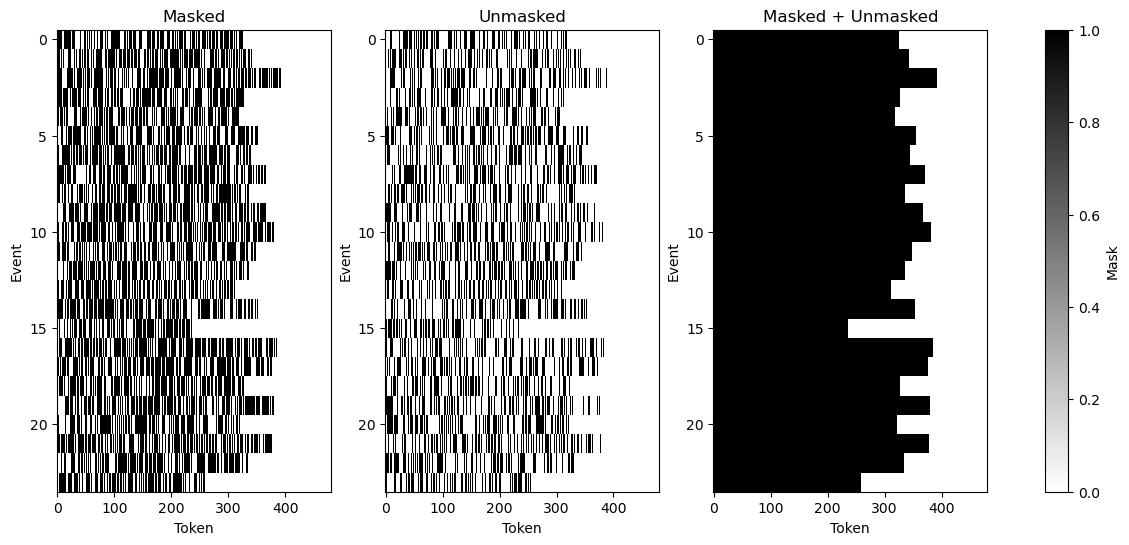

In [5]:
import matplotlib.pyplot as plt

# plot masked and unmasked masks for first event side by side in same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.imshow(masked.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax1.set_title('Masked')

ax2.imshow(unmasked.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax2.set_title('Unmasked')

ax3.imshow(embedding_mask.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax3.set_title('Masked + Unmasked')

cbar = fig.colorbar(ax3.images[0], ax=[ax1, ax2, ax3])
cbar.set_label('Mask')

ax1.set_xlabel('Token')
ax1.set_ylabel('Event')
ax2.set_xlabel('Token')
ax2.set_ylabel('Event')
ax3.set_xlabel('Token')
ax3.set_ylabel('Event')
plt.show()

In [6]:
w_m = masked.unsqueeze(-1)   # (B, T, 1)
w_u = unmasked.unsqueeze(-1) # (B, T, 1)

# Get positional encodings for centers
pos = positional_encoding(centers[..., :3])

# Get visible embeddings
visible_embeddings = w_u * embeddings

# Pass visible embeddings through encoder
# w_u is used to create the correct attention mask to ensure the encoder only attends to visible tokens
# and not masked/padded tokens
encoder_output = encoder(visible_embeddings, pos, w_u.bool().squeeze()).last_hidden_state

# Decoder mask == embedding_mask (i.e. attend to all non-padded tokens)
decoder_mask = embedding_mask

# Replace visible tokens in corrupted embeddings with encoder output
total_embeddings = encoder_output * w_u + w_m * mask_token

# Pass total embeddings through decoder
decoder_output = decoder(total_embeddings, pos, decoder_mask).last_hidden_state

# Get masked output embeddings
masked_output_embeddings = decoder_output[masked]

# Regress 4D points from masked output embeddings
regressed_points = increase_dim(masked_output_embeddings.transpose(0, 1)).transpose(0, 1)
regressed_points = regressed_points.reshape(regressed_points.shape[0], -1, num_channels)

ground_truth_points = groups[masked]

print('Regressed Points Shape:', regressed_points.shape)
print('Ground Truth Points Shape:', ground_truth_points.shape)

Regressed Points Shape: torch.Size([4921, 32, 4])
Ground Truth Points Shape: torch.Size([4921, 32, 4])


We now have the regressed points and the ground truth points. We can now compute the Chamfer Distance between the two. However, since the patches contain a variable number of points, we need to pass the actual lengths of each patch to the Chamfer Distance function.

In [7]:
from pytorch3d.loss import chamfer_distance

point_lengths = point_mask[masked].sum(-1)

chamfer_loss, _ = chamfer_distance(
    regressed_points,
    ground_truth_points,
    x_lengths=point_lengths,
    y_lengths=point_lengths,
)

print(chamfer_loss)

tensor(0.5928, device='cuda:0')


# Validation

A decent training metric to use to see if the encoder is learning good representations is to use a Support Vector Machine (SVM) to classify the points into different semantic classes.

The workflow is esssentially to:

1. Tokenize point cloud as usual.
2. Look at the semantic IDs of grouped points, taking the average semantic ID for each group (ie. most prevalent semantic ID for each group). This gives us a single semantic ID for each group/token.
3. Pass all tokens through the encoder (i.e., do no masking).
4. Train an SVM to classify the tokens into different semantic classes.
5. Log the training and validation accuracy of the SVM.


The following code does this. It's a little difficult to read as the method for getting the most prevalent semantic ID is vectorized and works in a non-obvious way.

In [8]:
# Max number of tokens to use for training/validation
max_tokens: int = 7500

def xy(dataloader):
    x_list = []
    label_list = []

    total =  max_tokens // (tokenizer.grouping.group_size * dataloader.batch_size) if max_tokens is not None else None

    for i, (data, lengths, labels_batch, _) in enumerate(dataloader):
        data = data.cuda()
        lengths = lengths.cuda()
        labels_batch = labels_batch.cuda()
        with torch.no_grad():
            tokens, centers, mask, semantic_ids, _, _, _ = tokenizer(
                data, lengths, labels_batch, return_point_info=True)
            pos = positional_encoding(centers[..., :3])
            x = encoder(tokens, pos, mask).last_hidden_state.reshape(-1, encoder_dim)
            semantic_ids = semantic_ids.reshape(-1, semantic_ids.shape[2])

            # Get semantic_ids for each group
            N = semantic_ids.shape[0]  # Number of groups
            D = semantic_ids.shape[1]  # Number of semantic IDs per group

            group_indices = torch.arange(N, device=semantic_ids.device).unsqueeze(1).expand(-1, D)  # Shape: (N, D)
            semantic_ids_flat = semantic_ids.reshape(-1)
            group_indices_flat = group_indices.reshape(-1)
            valid_mask = semantic_ids_flat != -1
            semantic_ids_valid = semantic_ids_flat[valid_mask]  # Shape: (K,)
            group_indices_valid = group_indices_flat[valid_mask]  # Shape: (K,)
            num_labels = semantic_ids_valid.max().item() + 1
            counts = torch.zeros((N, num_labels), dtype=torch.int64, device=semantic_ids.device)
            counts.index_add_(0, group_indices_valid, torch.nn.functional.one_hot(semantic_ids_valid, num_classes=num_labels).to(torch.int64))
            y = counts.argmax(dim=1)  # Shape: (N,)
            mask_flat = mask.reshape(-1)
            x = x[mask_flat]
            y = y[mask_flat]
            x_list.append(x.cpu())
            label_list.append(y.cpu())

            if total is not None and i >= total:
                break

    x = torch.cat(x_list, dim=0)[:max_tokens]
    y = torch.cat(label_list, dim=0)[:max_tokens]
    return x, y

x_train, y_train = xy(dataset.train_dataloader())  # type: ignore
x_val, y_val = xy(dataset.val_dataloader())  # type: ignore
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([7500, 384]),
 torch.Size([7500]),
 torch.Size([7500, 384]),
 torch.Size([7500]))

In [9]:
from sklearn.svm import SVC

svm_C = 0.01
svm = SVC(C=svm_C, kernel="linear", class_weight="balanced")
svm.fit(x_train, y_train)
train_acc = svm.score(x_train, y_train)
val_acc = svm.score(x_val, y_val)

print('Train Accuracy:', train_acc)
print('Validation Accuracy:', val_acc)

Train Accuracy: 0.6776
Validation Accuracy: 0.5796
